# Week4授業課題 信用情報を学習しよう

## 【問題1】パイプラインの作成

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm_notebook as tqdm


df_train = pd.read_csv('application_train.csv').sample(frac=1)[:50000]
df_X = df_train.drop("TARGET", axis=1)
df_Y = df_train[["TARGET"]]

#カテゴリーを数値変換
categorical_feats = [
    f for f in df_X.columns if df_X[f].dtype == 'object'
]
categorical_feats_ = categorical_feats.copy()

for f in categorical_feats_:
    df_X[f], _ = pd.factorize(df_X[f])
    df_X[f] = df_X[f].astype('int')
    
#残りの欠損値を平均で埋める
df_X = df_X.fillna(df_X.mean())

#データ分割
(X_train, X_test, 
     y_train, y_test) = train_test_split(df_X.values, df_Y.values.flatten(), test_size=0.3)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [2]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression().fit(X_train, y_train)
y_predict_logistic = clf_logistic.predict(X_test)
y_predict_proba_logistic = clf_logistic.predict_proba(X_test)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [3]:
estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

,accuracy,precision,recall,f1
LogisticRegression,0.918067,0.387097,0.00982,0.019154


In [4]:
"""
テストデータを読み込み、処理
"""

df_apptest = pd.read_csv('application_test.csv')

#カテゴリーを数値変換
categorical_feats = [
    f for f in df_apptest.columns if df_apptest[f].dtype == 'object'
]
categorical_feats_ = categorical_feats.copy()

for f in categorical_feats_:
    df_apptest[f], _ = pd.factorize(df_apptest[f])
    df_apptest[f] = df_apptest[f].astype('int')
    
#残りの欠損値を平均で埋める
df_apptest = df_apptest.fillna(df_apptest.mean())

X_apptest = df_apptest.values

#標準化
scaler.fit(X_apptest)
X_apptest = scaler.transform(X_apptest)

In [5]:
#予測
y_apt_predict_logistic = clf_logistic.predict(X_apptest)

In [6]:
"""
csvファイルへ書き込み
"""

import csv as csv

submit_file = open("home_credit_submit.csv", "w")
file_object = csv.writer(submit_file)
file_object.writerow(["SK_ID_CURR", "TARGET"])
file_object.writerows(zip(df_apptest["SK_ID_CURR"].values, y_predict_logistic))
submit_file.close()

uploadしてAUCが0.54だったのでかなり低い。ほぼ最低値

## 【問題2】指標値の関数作成

まずは、sklearnで用意されているroc_curveでグラフを描画し、イメージを掴む。  
AUC＝曲線の下側の面積なので、関数を作成し面積を求める。  
最後にsklearnに用意されているroc_auc_scoreで確認する。

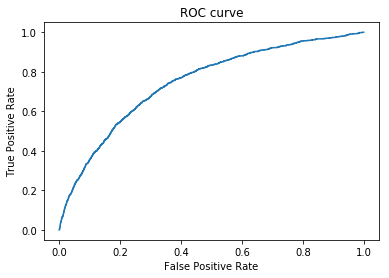

In [7]:
from sklearn import metrics

#ｆｐｒ、tpr、閾値を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_proba_logistic[:, 1])

#ROC曲線をプロット
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

AUCを求める関数を作成する手順  
①予測スコアとラベルをデータフレーム化し、予測スコアの降順でソート(df_auc_calculation)  
②関数を作成
　曲線の面積を求めるので、イメージ的には積分。  
　false_positiveの増加分×true_positiveの増加分で出来たの長方形の面積の逐次計算。  
　最後に面積の最大値であるfalse_positive×true_positiveとの割合を求める。

In [8]:
#予測スコアとラベルをデータフレーム化、予測スコア降順でソート
df_auc_calculation = pd.DataFrame({
    'score': y_predict_proba_logistic[:, 1],
    'label': y_test
}).sort_values('score', ascending=False)

In [9]:
#AUCを計算する式
def calculate_auc():
    true_positive = 0
    false_positive = 0
    sum = 0

    for i in df_auc_calculation[['label']].values.flatten():
        if i == 1:
            true_positive += 1
        else:
            sum += true_positive
            false_positive += 1
            
    total = sum / (true_positive * false_positive)
    
    return total

In [10]:
calculate_auc()

0.7461158102328269

In [11]:
#sklearnに用意されているAUC算出関数
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_predict_proba_logistic[:, 1])

0.7461158102328268

#### 考察
自作関数とroc_auc_scoreで求めた数値は同値であった。  
Kaggleで算出されたAUC0.54と算出したAUC0.74には大きな差があった。  
recallが低いということはFNが多かったということなので、Negativeと判断して間違えていたものが多い。  
元々のデータに偏り（おおよそ9:1）が影響していたと考えられる。  
さらに学習データとテストデータ分割でpositive:negative = 9:1になっていない可能性がある。  
問題３では分割後のクラスのバランスを確認し、悪ければ保持したまま分割させて精度を確認する。  
また、学習を１度だけでなく割合保持したまま複数回実施したほうがいいと考えられるがデータ数が多いので難しい。

## 【問題3】前処理・Feature Engineering・学習

#### クラスバランスが保持されているか確認

In [12]:
#トレーニングデータの「０」「１」数
np.unique(y_train, return_counts=True)

(array([0, 1]), array([32163,  2837]))

In [13]:
#トレーニングデータの「０」「１」の割合
np.unique(y_train, return_counts=True) [1]/ y_train.size

array([0.91894286, 0.08105714])

In [14]:
#検証データの「０」「１」の割合
np.unique(y_test, return_counts=True)[1] / y_test.size

array([0.91853333, 0.08146667])

おおよそ9:1が保たれていた。分割前後で保たれていたというということはやはりnegativeが少なすぎると言うこと。  
不均衡データではどの学習モデルが良いか確認のため、複数のモデルを使用して確認する。

### KNeighbors

In [ ]:
#KNeighbors（K=5）
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighbors=5の場合で学習
neigh_5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1)
neigh_5nn.fit(X_train, y_train)
y_predict_neigh_5nn = neigh_5nn.predict(X_test)
y_predict_proba_neigh_5nn = neigh_5nn.predict_proba(X_test)

estimation_neigh_5nn_dict = {
    "accuracy": accuracy_score(y_test, y_predict_neigh_5nn),
    "precision": precision_score(y_test, y_predict_neigh_5nn),
    "recall": recall_score(y_test, y_predict_neigh_5nn) ,
    "f1":f1_score(y_test, y_predict_neigh_5nn)
}
estimation_neigh_5nn = pd.DataFrame(estimation_neigh_5nn_dict, index=['KNeighborsClassifier'])

estimation_neigh_5nn


In [ ]:
roc_auc_score(y_test, y_predict_proba_neigh_5nn[:, 1])

### SVC

In [ ]:
# #SVC
from sklearn.svm import SVC

clf_svc = SVC(probability=True).fit(X_train, y_train)
y_predict_svc = clf_svc.predict(X_test)
y_predict_proba_svc = clf_svc.predict_proba(X_test)

estimation_svc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_svc),
    "precision": precision_score(y_test, y_predict_svc),
    "recall": recall_score(y_test, y_predict_svc),
    "f1":f1_score(y_test, y_predict_svc)
}

estimation_svc = pd.DataFrame(estimation_svc_dict, index=['Support Vector Classification'])
estimation_svc

In [ ]:
roc_auc_score(y_test, y_predict_proba_svc[:, 1])

### DecisionTreeClassifier

In [19]:
#DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_predict_dtc = clf_dtc.predict(X_test)
y_predict_proba_dtc = clf_dtc.predict_proba(X_test)

estimation_dtc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_dtc),
    "precision": precision_score(y_test, y_predict_dtc),
    "recall": recall_score(y_test, y_predict_dtc),
    "f1":f1_score(y_test, y_predict_dtc)
}
estimation_dtc = pd.DataFrame(estimation_dtc_dict, index=['DecisionTreeClassifier'])
estimation_dtc

,accuracy,precision,recall,f1
DecisionTreeClassifier,0.851533,0.144279,0.165579,0.154197


In [20]:
roc_auc_score(y_test, y_predict_proba_dtc[:, 1])

0.5390840273811855

### RandomForestClassifier

In [21]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

clf_rfc = RandomForestClassifier().fit(X_train, y_train)
y_predict_rfc = clf_rfc.predict(X_test)
y_predict_proba_rfc = clf_rfc.predict_proba(X_test)

estimation_rfc_dict = {
    "accuracy": accuracy_score(y_test, y_predict_rfc),
    "precision": precision_score(y_test, y_predict_rfc),
    "recall": recall_score(y_test, y_predict_rfc),
    "f1":f1_score(y_test, y_predict_rfc)
}
estimation_rfc = pd.DataFrame(estimation_rfc_dict, index=['RandomForestClassifier'])
estimation_rfc

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,accuracy,precision,recall,f1
RandomForestClassifier,0.917067,0.275,0.008972,0.017378


In [22]:
roc_auc_score(y_test, y_predict_proba_rfc[:, 1])

0.6237351159986271

パラメータを初期値のままで実施すると、ロジスティック回帰が一番よさそうなので、  
前処理を変更し、ロジスティック回帰で解析してみる。  
前処理として、①アンダーサンプリング、②オーバーサンプリング、③SMOTE　を試すことにする。

#### ①アンダーサンプリング

In [24]:
from imblearn.under_sampling import RandomUnderSampler

#ラベル１のサイズを格納
positive_count_train = y_train.sum()

# ラベル1が20％になるまでラベル0をダウンサンプリング
rus = RandomUnderSampler(ratio={0:positive_count_train*4, 1:positive_count_train}, random_state=71)

# 学習用データに反映
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)

In [25]:
np.unique(y_train_resampled, return_counts=True) [1]/ y_train_resampled.size

array([0.8, 0.2])

In [44]:
clf_logistic = LogisticRegression(class_weight='balanced', C=300).fit(X_train_resampled, y_train_resampled)
scores = cross_val_score(
    estimator=clf_logistic,  # 分類器を指定
    X=X_train_resampled,  # 特徴行列 X を指定
    y=y_train_resampled,  # 目的変数 y を指定
    cv=10  # データを何分割にして検証するか指定
)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3

In [45]:
scores

array([0.68313141, 0.69944082, 0.70161541, 0.70674122, 0.70891581,
       0.70037279, 0.7082945 , 0.71373097, 0.69655065, 0.71612803])

In [46]:
y_predict_logistic = clf_logistic.predict(X_test)
y_predict_proba_logistic = clf_logistic.predict_proba(X_test)

estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

,accuracy,precision,recall,f1
LogisticRegression,0.687733,0.158249,0.648013,0.254378


In [47]:
roc_auc_score(y_test, y_predict_proba_logistic[:, 1])

0.7272880227533771

#### ②オーバーサンプリング

In [48]:
from imblearn.over_sampling import RandomOverSampler

# 正例を10％まであげる
ros = RandomOverSampler(ratio = {0:X_train.shape[0], 1:X_train.shape[0]//4}, random_state = 71)

# 学習用データに反映
X_train_resampled, y_train_resampled = ros.fit_sample(X_train, y_train)


/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (35000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 32188)
  n_samples_majority))


In [49]:
np.unique(y_train_resampled, return_counts=True) [1]/ y_train_resampled.size

array([0.8, 0.2])

In [50]:
clf_logistic = LogisticRegression(class_weight='balanced', C=300).fit(X_train_resampled, y_train_resampled)
scores = cross_val_score(
    estimator=clf_logistic,  # 分類器を指定
    X=X_train_resampled,  # 特徴行列 X を指定
    y=y_train_resampled,  # 目的変数 y を指定
    cv=10  # データを何分割にして検証するか指定
)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3

In [51]:
scores

array([0.6864    , 0.69051429, 0.68091429, 0.69622857, 0.68937143,
       0.67542857, 0.69942857, 0.68274286, 0.68274286, 0.69965714])

In [52]:
y_predict_logistic = clf_logistic.predict(X_test)
y_predict_proba_logistic = clf_logistic.predict_proba(X_test)

estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

,accuracy,precision,recall,f1
LogisticRegression,0.685467,0.158132,0.65369,0.25466


In [53]:
roc_auc_score(y_test, y_predict_proba_logistic[:, 1])

0.7369107491726958

#### SMOTE

In [58]:
from imblearn.over_sampling import SMOTE

# ラベルを50％ずつにする
smote = SMOTE(random_state = 71)

# 学習用データに反映
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)


In [59]:
np.unique(y_train_resampled, return_counts=True) [1]/ y_train_resampled.size

array([0.5, 0.5])

In [60]:
clf_logistic = LogisticRegression(class_weight='balanced', C=300).fit(X_train_resampled, y_train_resampled)
scores = cross_val_score(
    estimator=clf_logistic,  # 分類器を指定
    X=X_train_resampled,  # 特徴行列 X を指定
    y=y_train_resampled,  # 目的変数 y を指定
    cv=10  # データを何分割にして検証するか指定
)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3

In [61]:
y_predict_logistic = clf_logistic.predict(X_test)
y_predict_proba_logistic = clf_logistic.predict_proba(X_test)

estimation_logistic_dict = {
    "accuracy": accuracy_score(y_test, y_predict_logistic),
    "precision": precision_score(y_test, y_predict_logistic),
    "recall": recall_score(y_test, y_predict_logistic),
    "f1":f1_score(y_test, y_predict_logistic)
}

estimation_logistic = pd.DataFrame(estimation_logistic_dict, index=['LogisticRegression'])
estimation_logistic

,accuracy,precision,recall,f1
LogisticRegression,0.687733,0.158249,0.648013,0.254378


In [62]:
roc_auc_score(y_test, y_predict_proba_logistic[:, 1])

0.7272880227533771